### CSV Export
This section exports the supernova fitting results to a CSV file for further analysis.

### Import libraries

In [72]:
from pylab import *
import numpy as np
from matplotlib import rc
import os
from scipy.interpolate import interp1d
import pandas as pd  # For CSV export

# Specific libraries
import cosmolib as cs

# Visuals
rc('figure',figsize=(10,5))
rc('font',size=12)
rc('text',usetex=False)

### IMINUIT

In [73]:
# Load redshift data
redshifts = np.loadtxt('data/Data-LightCurves/EI2019-Data-LightCurves-SN-Redshifts.txt')

# Load template lightcurve
t_template, mag_template = np.loadtxt('data/Data-LightCurves/EI2019-Data-LightCurves-SN-SNI-Average_LightCurve.txt').T

# Intrinsic error parameter (magnitude)
sigma_int = 0.1  # Typical intrinsic scatter for SN Ia (can be adjusted)

class SNIaLightCurve:
    def __init__(self, template_data):
        self.template_t = template_data[0]
        self.template_mag = template_data[1]
        self.interpolator = interp1d(
            self.template_t,
            self.template_mag,
            kind='linear',
            fill_value='extrapolate',
            bounds_error=False
        )
        
    def __call__(self, t, pars):
        # pars : [t0, s, mu] where:
        # t0 : time of maximum brightness
        # s : stretch parameter (brighter-slower effect)
        # mu : distance modulus
        t0, s, mu = pars
        
        # Apply time stretch and shift
        t_stretched = (t - t0) / s
        
        # Interpolate template at stretched times using scipy interpolator
        mag_intrinsic = self.interpolator(t_stretched)
        
        # Apply brighter-slower correction: -1.52*(s-1) and add distance modulus
        mag_observed = mag_intrinsic - 1.52*(s-1) + mu
        
        return mag_observed

# Initialize template lightcurve
lc_template = SNIaLightCurve([t_template, mag_template])

# Arbitrary cosmological parameters to initialize mu_guess 
cosmo_pars = {'h': 0.7, 'omega_M_0': 0.3895, 'omega_lambda_0': 0.3895, 'w0': -1}

# Function to fit individual supernova
def fit_supernova_lightcurve(sn_number, redshift, lc_template, sigma_int, verbose=False):
    """
    Fit a single supernova lightcurve to extract distance modulus
    """
    # Load supernova data
    filename = f'data/Data-LightCurves/EI2019-Data-LightCurves-SN-{sn_number}_lightcurve.txt'
    if not os.path.exists(filename):
        return None
        
    data = np.loadtxt(filename)
    t_obs = data[:, 0]  # observed time
    mag_obs = data[:, 1]  # observed magnitude
    mag_err = data[:, 2]  # magnitude errors
    
    # Add intrinsic error in quadrature
    total_mag_err = np.sqrt(mag_err**2 + sigma_int**2)
    
    # Convert to rest frame time
    t_rest = t_obs / (1 + redshift)
    
    # Initial guess: t0=0, s=1, mu=reasonable distance modulus for the redshift
    # Rough distance modulus estimate from redshift (assuming flat ΛCDM) (Omega_k = 0, according to our arbitrary cosmological parameters)
    mu_guess = cs.musn1a(redshift, cosmo_pars)
    # mu_guess = 35.0

    # Initial guess = [t0, s, mu]
    t0_guess = t_rest[np.argmin(mag_obs)]
    guess = np.array([t0_guess, 1.0, mu_guess])
    
    try:
        # Fit using Minuit with total error (including intrinsic scatter)
        result = cs.do_minuit(t_rest, mag_obs, total_mag_err, guess, 
                             functname=lc_template, verbose=verbose)
        
        fitm, fitted_values, errors, covariance, chi2, ndf = result
        
        return {
            'sn_number': sn_number,
            'redshift': redshift,
            't0': fitted_values[0],
            't0_err': errors[0],
            's': fitted_values[1],
            's_err': errors[1],
            'mu': fitted_values[2],
            'mu_err': errors[2],
            'chi2': chi2,
            'ndf': ndf,
            'chi2_reduced': chi2/ndf if ndf > 0 else np.inf,
            'sigma_int_used': sigma_int
        }
    except Exception as e:
        if verbose:
            print(f"Fitting failed for SN-{sn_number}: {e}")
        return None

# Fit all supernovae
print(f"Fitting individual supernova lightcurves with intrinsic error σ_int = {sigma_int:.3f} mag...")
fitting_results = []

for i in range(len(redshifts)):
    print(f"Fitting SN-{i}...")
    result = fit_supernova_lightcurve(i, redshifts[i], lc_template, sigma_int=sigma_int, verbose=True)
    if result is not None:
        fitting_results.append(result)
        print(f"SN-{i}: μ = {result['mu']:.3f} ± {result['mu_err']:.3f}, s = {result['s']:.3f} ± {result['s_err']:.3f}")
    print()

print(f"Successfully fitted {len(fitting_results)} supernovae")

# Display results
if fitting_results:
    print("\nFitting Results Summary:")
    print("SN\tRedshift\tμ ± σ_μ\t\ts ± σ_s\t\tχ²/ndf")
    print("-" * 70)
    for result in fitting_results:
        print(f"{result['sn_number']}\t{result['redshift']:.3f}\t\t{result['mu']:.3f} ± {result['mu_err']:.3f}\t{result['s']:.3f} ± {result['s_err']:.3f}\t{result['chi2_reduced']:.2f}")

    print(f"\nNote: All fits include intrinsic scatter σ_int = {sigma_int:.3f} mag")



Fitting individual supernova lightcurves with intrinsic error σ_int = 0.100 mag...
Fitting SN-0...
Fitting with Minuit
Chi2 = 14.632459423773001
ndf = 17
Fitted values:
[-0.25579598  1.04047847 43.65417816]
Errors:
[0.62855847 0.07407099 0.13457316]
Covariance:
[[ 0.39508574 -0.03546377 -0.05530925]
 [-0.03546377  0.00548651  0.0097041 ]
 [-0.05530925  0.0097041   0.01810994]]
SN-0: μ = 43.654 ± 0.135, s = 1.040 ± 0.074

Fitting SN-1...
Fitting with Minuit
Chi2 = 16.445184821651246
ndf = 17
Fitted values:
[ 3.14849734  0.93503083 41.93578563]
Errors:
[0.17706866 0.02447491 0.06846063]
Covariance:
[[0.03135331 0.00129705 0.00361865]
 [0.00129705 0.00059902 0.00157896]
 [0.00361865 0.00157896 0.00468686]]
SN-1: μ = 41.936 ± 0.068, s = 0.935 ± 0.024

Fitting SN-2...
Fitting with Minuit
Chi2 = 14.94596743359877
ndf = 17
Fitted values:
[-1.89039185  1.10811848 43.73471501]
Errors:
[0.33971276 0.05391943 0.1064058 ]
Covariance:
[[ 0.11540476 -0.00945469 -0.0132182 ]
 [-0.00945469  0.00290731

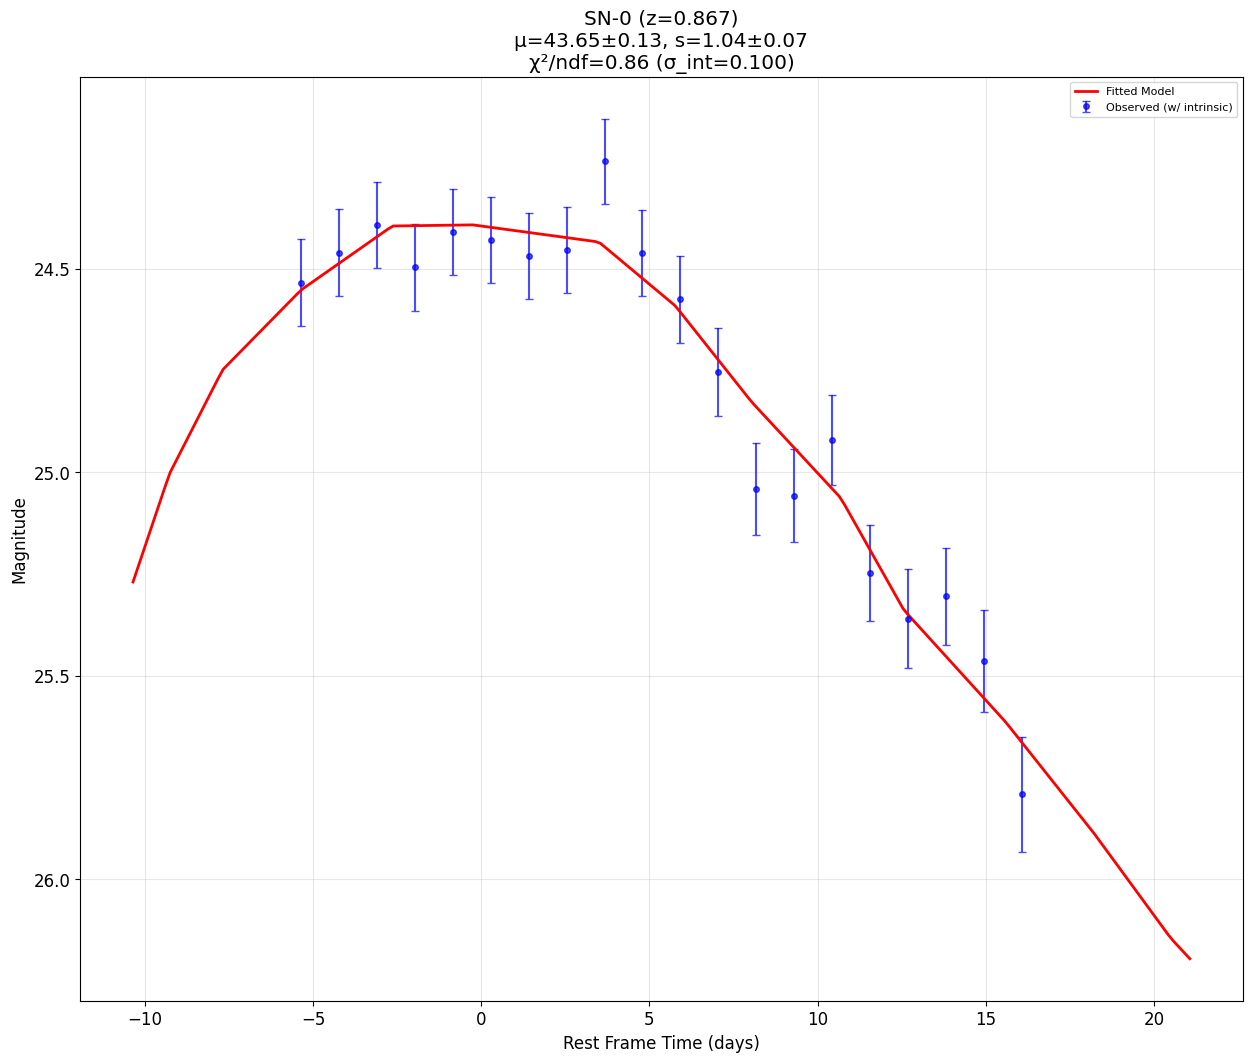

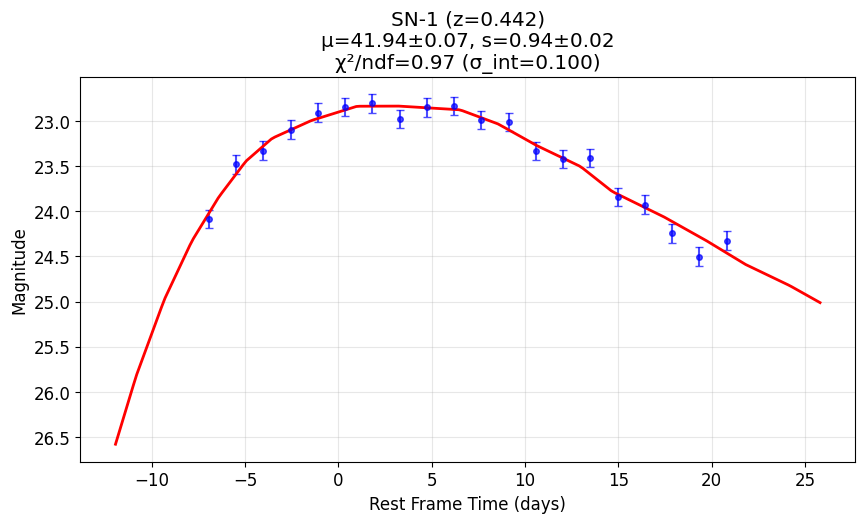


Displayed fitted lightcurves for the first 2 supernovae
Each plot shows:
- Blue points: Observed photometry with total error bars (observational + intrinsic)
- Red line: Best-fit template lightcurve
- Title includes redshift, fitted parameters (μ, s), χ²/ndf, and σ_int=0.100
- Total error = sqrt(observational_error² + 0.100²)


In [74]:
# Plot fitted lightcurves for visualization
if fitting_results:
    # Select a subset of supernovae to plot (first 9 for a 3x3 grid)
    n_plot = min(2, len(fitting_results))
    
    figure(figsize=(15, 12))
    
    for i in range(n_plot):
        result = fitting_results[i]
        sn_number = result['sn_number']
        redshift = result['redshift']
        sigma_int_used = result.get('sigma_int_used', sigma_int)
        
        # Load observed data
        filename = f'data/Data-LightCurves/EI2019-Data-LightCurves-SN-{sn_number}_lightcurve.txt'
        if os.path.exists(filename):
            data = np.loadtxt(filename)
            t_obs = data[:, 0]
            mag_obs = data[:, 1]
            mag_err = data[:, 2]
            
            # Calculate total error (including intrinsic scatter)
            total_mag_err = np.sqrt(mag_err**2 + sigma_int_used**2)
            
            # Convert to rest frame
            t_rest = t_obs / (1 + redshift)
            
            # Generate fitted lightcurve
            t_model = np.linspace(t_rest.min() - 5, t_rest.max() + 5, 200)
            fitted_pars = [result['t0'], result['s'], result['mu']]
            mag_model = lc_template(t_model, fitted_pars)
            
            # Plot in subplot
            
            
            # Plot observed data with total error bars
            errorbar(t_rest, mag_obs, yerr=total_mag_err, fmt='o', 
                    capsize=3, markersize=4, alpha=0.7, label='Observed (w/ intrinsic)', color='blue')
            
            # Plot fitted model
            plot(t_model, mag_model, 'r-', linewidth=2, label='Fitted Model')
            
            # Formatting with chi² value in title
            xlabel('Rest Frame Time (days)')
            ylabel('Magnitude')
            title(f'SN-{sn_number} (z={redshift:.3f})\nμ={result["mu"]:.2f}±{result["mu_err"]:.2f}, s={result["s"]:.2f}±{result["s_err"]:.2f}\nχ²/ndf={result["chi2_reduced"]:.2f} (σ_int={sigma_int_used:.3f})')
            grid(True, alpha=0.3)
            gca().invert_yaxis()  # Invert y-axis for magnitudes (brighter = lower values)
            
            if i == 0:  # Only show legend for first subplot
                legend(loc='upper right', fontsize=8)
            show()
    
    #tight_layout()
    #title('Fitted Supernova Lightcurves (First 9 SNe)', fontsize=16, y=0.98)
    #show()
    
    print(f"\nDisplayed fitted lightcurves for the first {n_plot} supernovae")
    print("Each plot shows:")
    print("- Blue points: Observed photometry with total error bars (observational + intrinsic)")
    print("- Red line: Best-fit template lightcurve")
    print(f"- Title includes redshift, fitted parameters (μ, s), χ²/ndf, and σ_int={sigma_int:.3f}")
    print(f"- Total error = sqrt(observational_error² + {sigma_int:.3f}²)")

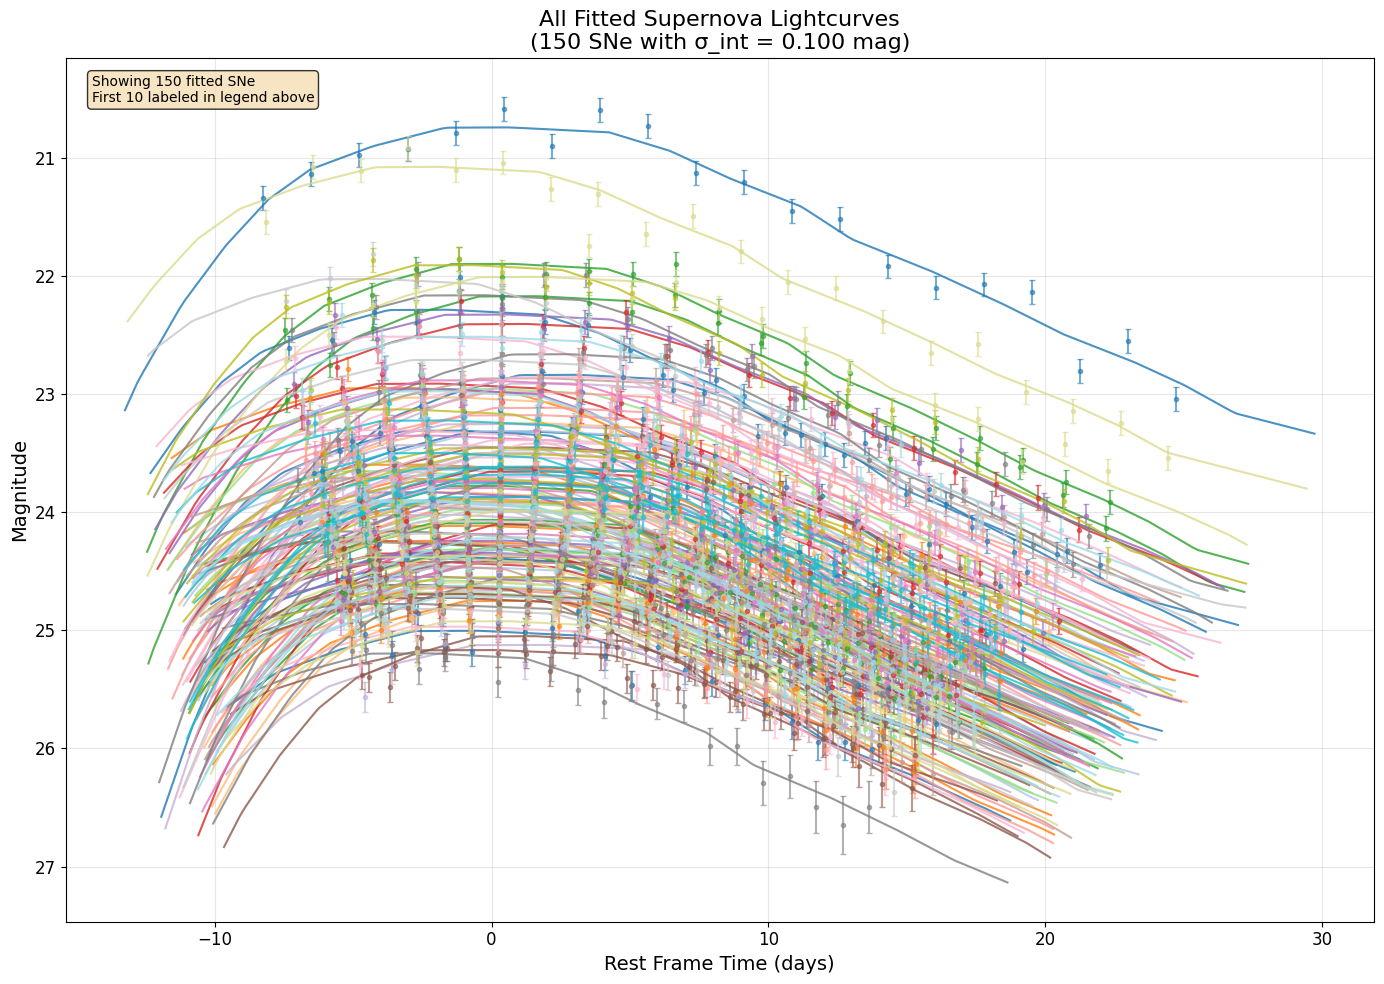


Displayed all 150 fitted lightcurves on the same plot
- Intrinsic scatter σ_int = 0.100 mag included in error bars

Parameter ranges:
- Redshift: 0.213 to 1.263
- Distance modulus μ: 39.95 to 44.60
- Stretch parameter s: 0.850 to 1.308


In [78]:
# Plot all fitted lightcurves on the same plot
if fitting_results:
    figure(figsize=(14, 10))
    
    # Create color map for different supernovae
    colors = plt.cm.tab20(np.linspace(0, 1, len(fitting_results)))
    
    # Plot all lightcurves
    for i, result in enumerate(fitting_results):
        sn_number = result['sn_number']
        redshift = result['redshift']
        sigma_int_used = result.get('sigma_int_used', sigma_int)
        
        # Load observed data
        filename = f'data/Data-LightCurves/EI2019-Data-LightCurves-SN-{sn_number}_lightcurve.txt'
        if os.path.exists(filename):
            data = np.loadtxt(filename)
            t_obs = data[:, 0]
            mag_obs = data[:, 1]
            mag_err = data[:, 2]
            
            # Calculate total error (including intrinsic scatter)
            total_mag_err = np.sqrt(mag_err**2 + sigma_int_used**2)
            
            # Convert to rest frame
            t_rest = t_obs / (1 + redshift)
            
            # Generate fitted lightcurve
            t_model = np.linspace(t_rest.min() - 5, t_rest.max() + 5, 200)
            fitted_pars = [result['t0'], result['s'], result['mu']]
            mag_model = lc_template(t_model, fitted_pars)
            
            # Plot observed data points with smaller markers
            errorbar(t_rest, mag_obs, yerr=total_mag_err, fmt='o', 
                    capsize=2, markersize=3, alpha=0.6, color=colors[i],
                    label=f'SN-{sn_number} (z={redshift:.3f})' if i < 10 else None)
            
            # Plot fitted model with same color
            plot(t_model, mag_model, '-', linewidth=1.5, alpha=0.8, color=colors[i])
    
    # Formatting
    xlabel('Rest Frame Time (days)', fontsize=14)
    ylabel('Magnitude', fontsize=14)
    title(f'All Fitted Supernova Lightcurves\n({len(fitting_results)} SNe with σ_int = {sigma_int:.3f} mag)', fontsize=16)
    grid(True, alpha=0.3)
    gca().invert_yaxis()  # Invert y-axis for magnitudes (brighter = lower values)
    
    # Add legend only for first 10 SNe to avoid clutter
    if len(fitting_results) <= 10:
        legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    else:
        # Add text box with summary info instead of legend
        textstr = f'Showing {len(fitting_results)} fitted SNe\nFirst 10 labeled in legend above'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        text(0.02, 0.98, textstr, transform=gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    tight_layout()
    show()
    
    print(f"\nDisplayed all {len(fitting_results)} fitted lightcurves on the same plot")
    print(f"- Intrinsic scatter σ_int = {sigma_int:.3f} mag included in error bars")
    
    # Print some statistics about the range of parameters
    mu_values = [r['mu'] for r in fitting_results]
    s_values = [r['s'] for r in fitting_results]
    z_values = [r['redshift'] for r in fitting_results]
    
    print(f"\nParameter ranges:")
    print(f"- Redshift: {min(z_values):.3f} to {max(z_values):.3f}")
    print(f"- Distance modulus μ: {min(mu_values):.2f} to {max(mu_values):.2f}")
    print(f"- Stretch parameter s: {min(s_values):.3f} to {max(s_values):.3f}")

In [75]:
# Export results to CSV file
if fitting_results:
    # Convert results to DataFrame
    df_results = pd.DataFrame(fitting_results)
    
    # Reorder columns for better readability
    column_order = ['sn_number', 'redshift', 'mu', 'mu_err', 's', 's_err', 't0', 't0_err', 
                   'chi2', 'ndf', 'chi2_reduced', 'sigma_int_used']
    df_results = df_results[column_order]
    
    # Add some additional computed columns for analysis
    df_results['mu_significance'] = df_results['mu'] / df_results['mu_err']
    df_results['s_significance'] = abs(df_results['s'] - 1.0) / df_results['s_err']
    
    # Create output filename with timestamp
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_filename = f'supernova_fitting_results_{timestamp}.csv'
    
    # Save to CSV
    df_results.to_csv(output_filename, index=False, float_format='%.6f')
    
    print(f"\n=== CSV Export Complete ===")
    print(f"Results saved to: {output_filename}")
    print(f"Number of supernovae: {len(df_results)}")
    print(f"Columns exported: {', '.join(df_results.columns)}")
    
    # Display basic statistics
    print(f"\n=== Summary Statistics ===")
    print(f"Distance modulus μ:")
    print(f"  Mean: {df_results['mu'].mean():.3f} ± {df_results['mu'].std():.3f}")
    print(f"  Range: [{df_results['mu'].min():.3f}, {df_results['mu'].max():.3f}]")
    print(f"Stretch parameter s:")
    print(f"  Mean: {df_results['s'].mean():.3f} ± {df_results['s'].std():.3f}")
    print(f"  Range: [{df_results['s'].min():.3f}, {df_results['s'].max():.3f}]")
    print(f"Reduced χ²:")
    print(f"  Mean: {df_results['chi2_reduced'].mean():.2f}")
    print(f"  Good fits (χ²/ndf < 2): {(df_results['chi2_reduced'] < 2).sum()}/{len(df_results)} ({100*(df_results['chi2_reduced'] < 2).mean():.1f}%)")
    
    # Display first few rows for verification
    print(f"\n=== First 5 rows of exported data ===")
    print(df_results.head().to_string(index=False, float_format=lambda x: f'{x:.4f}'))
else:
    print("No fitting results to export!")


=== CSV Export Complete ===
Results saved to: supernova_fitting_results_20250603_161250.csv
Number of supernovae: 150
Columns exported: sn_number, redshift, mu, mu_err, s, s_err, t0, t0_err, chi2, ndf, chi2_reduced, sigma_int_used, mu_significance, s_significance

=== Summary Statistics ===
Distance modulus μ:
  Mean: 43.011 ± 0.841
  Range: [39.945, 44.600]
Stretch parameter s:
  Mean: 1.017 ± 0.090
  Range: [0.850, 1.308]
Reduced χ²:
  Mean: 1.25
  Good fits (χ²/ndf < 2): 138/150 (92.0%)

=== First 5 rows of exported data ===
 sn_number  redshift      mu  mu_err      s  s_err      t0  t0_err    chi2  ndf  chi2_reduced  sigma_int_used  mu_significance  s_significance
         0    0.8670 43.6542  0.1346 1.0405 0.0741 -0.2558  0.6286 14.6325   17        0.8607          0.1000         324.3899          0.5465
         1    0.4420 41.9358  0.0685 0.9350 0.0245  3.1485  0.1771 16.4452   17        0.9674          0.1000         612.5533          2.6545
         2    0.9487 43.7347  0.1064

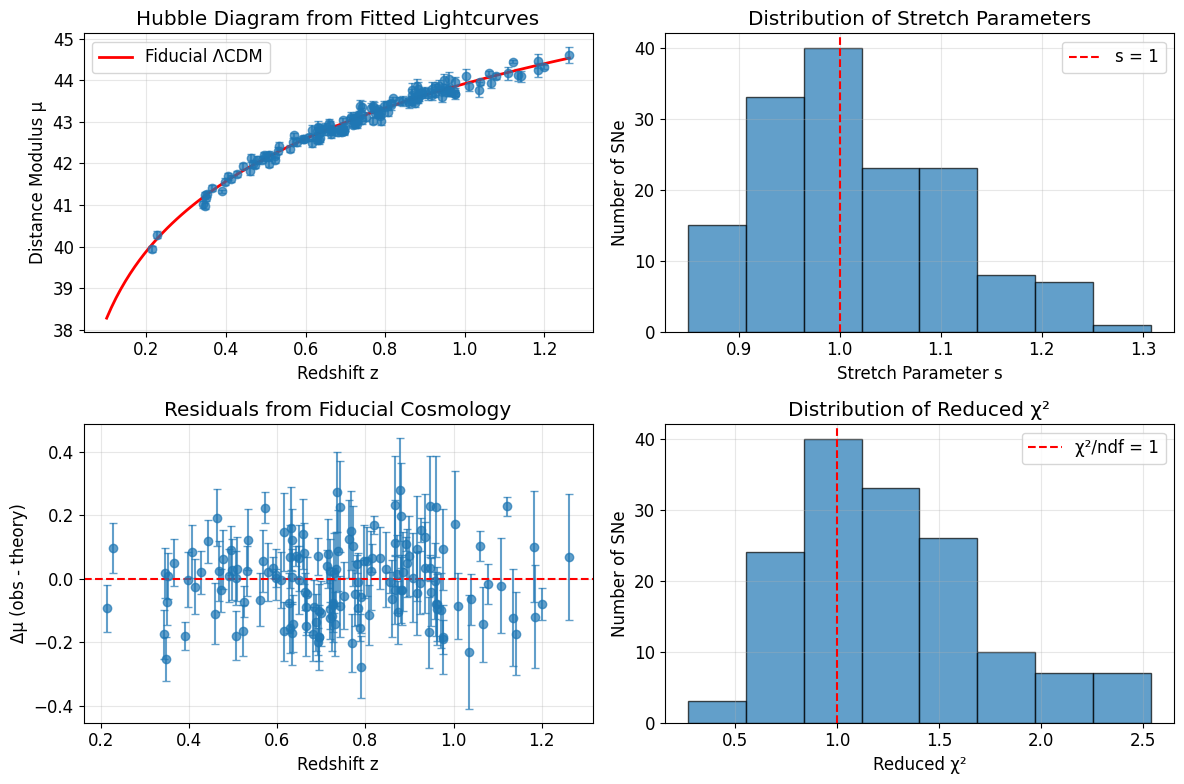


Statistics for 150 fitted supernovae:
Mean stretch parameter: 1.017 ± 0.089
Mean reduced χ²: 1.253 ± 0.467
RMS of residuals: 0.118 mag


In [76]:
# Create Hubble Diagram from fitted distance moduli
if fitting_results:
    # Extract data for plotting
    redshifts_fitted = [r['redshift'] for r in fitting_results]
    mu_fitted = [r['mu'] for r in fitting_results]
    mu_err_fitted = [r['mu_err'] for r in fitting_results]
    stretch_fitted = [r['s'] for r in fitting_results]
    
    # Plot Hubble Diagram
    figure(figsize=(12, 8))
    
    subplot(2, 2, 1)
    errorbar(redshifts_fitted, mu_fitted, yerr=mu_err_fitted, fmt='o', 
             capsize=3, markersize=6, alpha=0.7)
    xlabel('Redshift z')
    ylabel('Distance Modulus μ')
    title('Hubble Diagram from Fitted Lightcurves')
    grid(True, alpha=0.3)
    
    # Compare with theoretical prediction
    z_theory = np.linspace(0.1, max(redshifts_fitted), 100)
    mu_theory = cs.musn1a(z_theory, cosmo_pars)
    plot(z_theory, mu_theory, 'r-', label='Fiducial ΛCDM', linewidth=2)
    legend()
    
    # Plot stretch parameter distribution
    subplot(2, 2, 2)
    hist(stretch_fitted, bins=8, alpha=0.7, edgecolor='black')
    xlabel('Stretch Parameter s')
    ylabel('Number of SNe')
    title('Distribution of Stretch Parameters')
    axvline(1.0, color='red', linestyle='--', label='s = 1')
    legend()
    grid(True, alpha=0.3)
    
    # Plot residuals from fiducial cosmology
    subplot(2, 2, 3)
    mu_theory_at_z = cs.musn1a(np.array(redshifts_fitted), cosmo_pars)
    residuals = np.array(mu_fitted) - mu_theory_at_z
    errorbar(redshifts_fitted, residuals, yerr=mu_err_fitted, fmt='o', 
             capsize=3, markersize=6, alpha=0.7)
    axhline(0, color='red', linestyle='--')
    xlabel('Redshift z')
    ylabel('Δμ (obs - theory)')
    title('Residuals from Fiducial Cosmology')
    grid(True, alpha=0.3)
    
    # Plot χ² distribution
    subplot(2, 2, 4)
    chi2_reduced = [r['chi2_reduced'] for r in fitting_results if np.isfinite(r['chi2_reduced'])]
    hist(chi2_reduced, bins=8, alpha=0.7, edgecolor='black')
    xlabel('Reduced χ²')
    ylabel('Number of SNe')
    title('Distribution of Reduced χ²')
    axvline(1.0, color='red', linestyle='--', label='χ²/ndf = 1')
    legend()
    grid(True, alpha=0.3)
    
    tight_layout()
    show()
    
    # Print statistics
    print(f"\nStatistics for {len(fitting_results)} fitted supernovae:")
    print(f"Mean stretch parameter: {np.mean(stretch_fitted):.3f} ± {np.std(stretch_fitted):.3f}")
    print(f"Mean reduced χ²: {np.mean(chi2_reduced):.3f} ± {np.std(chi2_reduced):.3f}")
    print(f"RMS of residuals: {np.sqrt(np.mean(residuals**2)):.3f} mag")